# Debug SimulationLog.jl

example: ERROR: LoadError: BoundsError: attempt to access 1-element Vector{Vector{Float64}} at index [-99:1]

In [1]:
using MAT
using Plots
using LinearAlgebra
using DifferentialEquations
using Random
using Statistics
using LaTeXStrings

In [2]:
# input C,G,R,S
loaded = matread("allsamples.mat")
loaded1 = matread("LinLogsamples.mat")

C_span = Float64.(loaded["allC"])
G_span = Float64.(loaded["allG"])
Sstar_span = Float64.(loaded["allSstar"])
Rstar_span = Float64.(loaded["allRstar"])
g_span = Float64.(loaded1["allg"])
K_span = Float64.(loaded1["allK"])

Nr = loaded["Nr"]
Ns_span = loaded["Ns_span"]

num_try = loaded["num_try"]
rho_span = Float64.(loaded["rho_span"])
batch_size = 10 # 10 different initial conditions

10

In [3]:
# Read in file of function
include("./RCMfunction.jl")

ResConLog! (generic function with 1 method)

In [109]:
i = 28 # for Ns
Ns = Ns_span[i]

j = 1 # rho totally 144

C = C_span[i,j,1:Ns,:]
G = G_span[i,j,1:Ns,:]

k = 2

Sstar = Sstar_span[i,j,k,1:Ns]
Rstar = Rstar_span[i,j,k,:]

δ = G * Rstar
g = g_span[i,j,k,:]
K = K_span[i,j,k,:]

32-element Vector{Float64}:
 20.6677188873291
  4.462686538696289
  5.227431774139404
  2.321692705154419
 40.485267639160156
 22.18129539489746
  5.4131598472595215
 28.37459373474121
  8.500810623168945
  9.403846740722656
  ⋮
  8.103399276733398
 18.528169631958008
  6.520754337310791
  1.4088267087936401
  9.144124031066895
  3.5450565814971924
 15.104752540588379
 11.514631271362305
  5.279103755950928

In [110]:
u0 = zeros(Ns+Nr)
u0[1:Ns] = Sstar .* (1 .+ .5*(rand(Ns) .- 0.5))
u0[Ns+1:end] = Rstar .* (1 .+ .5*(rand(Nr) .- 0.5))

iter = 1

tspan = (0.0, 5000.0) # time for one test solution
para = (Ns,Nr,G,C,g,K,δ)

stop = 0
fstate = zeros(Ns+2) # fstate[1:Ns]: species abundance; fstate[Ns+1]: flucturate or not; 
# fstate[Ns+2]: surviving fraction
while stop == 0
    prob = ODEProblem(ResConLog!,u0,tspan,para)
    #VCABM3() or Tsit5() or TRBDF2()
    # need to enforce positivity!!!
    global sol = solve(prob, saveat = 10.0, TRBDF2(), isoutofdomain = (u,p,t)->any(x->x < 0.0,u))
    meanS = mean(sol.u[end-100:end])[1:Ns]
    global index = findall(meanS .> 1e-5)
    global flagS = mean(abs.((sol.u[end][index] - meanS[index])./meanS[index]))
    if iter == 15 || flagS <= 1e-3
        stop = 1
    end
    iter = iter + 1
    u0 = sol.u[end]
    u0[u0 .< 1.0e-9] .= 1.0e-9
end

print("running time = ",(iter-1)*5000," surviving fraction: ", length(index)/Ns)

fluc = 0
if (flagS > 0.05) & (iter == 16)
    fluc = 1
end

fstate[1:Ns] = u0[1:Ns] # so we don't need to global sol later!
fstate[Ns+1] = fluc
fstate[Ns+2] = length(index)/Ns

running time = 5000 surviving fraction: 0.03225806451612903

0.03225806451612903

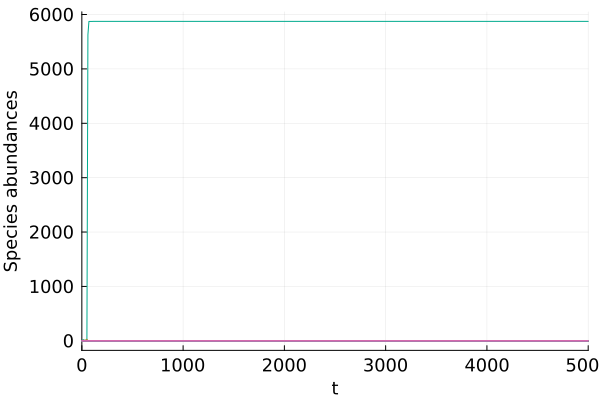

In [111]:
plot(sol,idxs = 1:Ns,legend = false,
    ylabel="Species abundances",
    xtickfont=font(12),
    ytickfont=font(12),
    guidefont=font(12),
    legendfont=font(12))

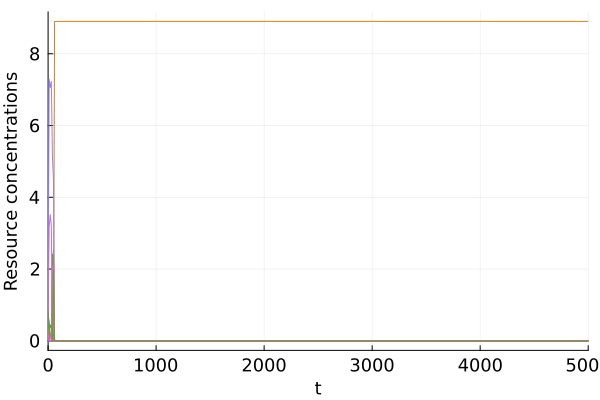

In [112]:
plot(sol,idxs = Ns+1:Ns+Nr,legend = false,
    ylabel="Resource concentrations",
    xtickfont=font(12),
    ytickfont=font(12),
    guidefont=font(12),
    legendfont=font(12))